# Homework 7
## Validation
In the following problems, use the data provided in the files `in.dta` and `out.dta` for Homework # 6. We are going to apply linear regression with a nonlinear transformation for classification (without regularization). The nonlinear transformation is given by $\phi_0$ through $\phi_7$ which transform $(x_1, x_2)$ into
$$
(1, x_1, x_2, x^2_1, x^2_2, x_1x_2, |x_1-x_2|, |x_1+x_2|)
$$  

To illustrate how taking out points for validation affects the performance, we will consider the hypotheses trained on $\mathcal D_{train}$ (without restoring the full $\mathcal D$ for training after validation is done).  

### Question 1 
Split `in.dta` into training (first 25 examples) and validation (last 10 examples). Train on the 25 examples only, using the validation set of 10 examples to select between five models that apply linear regression to $\phi_0$ through $\phi_k$, with $k = 3, 4, 5, 6, 7$. For which model is the classification error on the validation set smallest?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
def lr_in_val():
    # Compute the weights
    wg = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),y)
    
    # Estimate hypothesis
    g = np.where(np.dot(X,wg) >= 0, 1, -1)
        
    # Compute in-sample error
    Error = g - y
    Ein = np.count_nonzero(Error)/N
    
    gv = np.where(np.dot(Xv,wg) >= 0, 1, -1)
    Error_v = gv - yv
    Eval = np.count_nonzero(Error_v)/Nv
       
    lr_out = {'w': wg,
              'Ein': Ein,
              'Eval': Eval}
    
    return lr_out

In [3]:
def data_split(train_n, X):
    train = X[:train_n,:]
    val = X[train_n:X.shape[0]+1,:]
    return train, val

In [4]:
def x_transform(X):
    x1 = X[:,0]
    x2 = X[:,1]
    N = x1.shape[0]
    return np.column_stack([np.ones(N),
                            X,
                            X**2,
                            x1*x2,
                            np.absolute(x1 - x2),
                            np.absolute(x1 + x2)])

In [5]:
# Import data
in_data = np.loadtxt('Data/in.dta')
out_data = np.loadtxt('Data/out.dta')
print('The dimensions of the train data sample is :',in_data.shape)
print('The dimensions of the test data sample is :',out_data.shape)

The dimensions of the train data sample is : (35, 3)
The dimensions of the test data sample is : (250, 3)


First we split the input data set to get train and validation data set where `train` data set should have first 25 examples and the rest should be allocated to `val` data set.

In [6]:
#np.random.shuffle(in_data) # shuffle data to randomly select train and test

train_n = 25 # number of examples for the train set
train, val = data_split(train_n, in_data)
train_x = train[:,:2]
train_y = train[:,2]
val_x = val[:,:2]
val_y = val[:,2]
N = train_x.shape[0]
Nv = val_x.shape[0]

Apply data transformation to both `train` and `val` data sets.

In [7]:
Z = x_transform(train_x)
Zv = x_transform(val_x)

In [8]:
# Choose models we want to test
k = [3,4,5,6,7]

E_val = []
wg = []
for i in k:
    X = Z[:,:i+1]
    Xv = Zv[:,:i+1]
    y = train_y
    yv = val_y
    Nv = Xv.shape[0]
    lr_out = lr_in_val()
    E_val.append(lr_out['Eval'])
    wg.append(lr_out['w'])

In [9]:
d = {'k':k, 'E_val':E_val}
pd.DataFrame(data = d)

,E_val,k
0,0.3,3
1,0.5,4
2,0.2,5
3,0.0,6
4,0.1,7


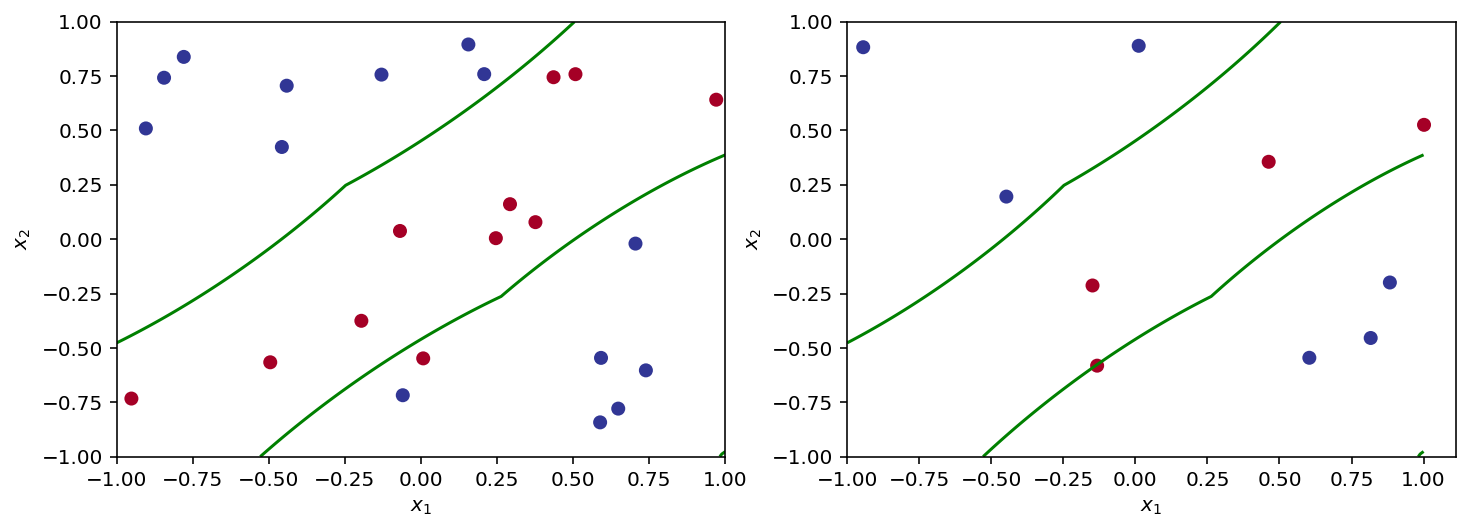

In [10]:
u = np.linspace(-1.,1., 1000)
A,B = np.meshgrid(u,u)

# k = 6
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
z = wg[4][0] + wg[4][1]*A + wg[4][2]*B + wg[4][3]*A**2 + wg[4][4]*B**2 + wg[4][5]*A*B + wg[4][6]*np.absolute(A-B) + wg[4][7]*np.absolute(A + B)
plt.scatter(train_x[:,0], train_x[:,1], c=y, cmap=plt.get_cmap('RdYlBu',2))
db = plt.contour(A, B, z, levels = [0], colors = 'green') # lambda = 0
plt.ylabel(r'$x_2$')
plt.xlabel(r'$x_1$')

plt.subplot(1,2,2)
plt.scatter(val_x[:,0], val_x[:,1], c=yv, cmap=plt.get_cmap('RdYlBu',2))
db = plt.contour(A, B, z, levels = [0], colors = 'green') # lambda = 0
plt.ylabel(r'$x_2$')
plt.xlabel(r'$x_1$')
plt.show()

Answer is (d).

### Question 2
Evaluate the out-of-sample classification error using `out.dta` on the 5 models to see how well the validation set predicted the best of the 5 models. For which model is the out-of-sample classification error smallest?

**Answer**: The weights of all five models are stored in `w` which we will use in this problem.

In [11]:
def lr_test(Xt,yt,w):        
    # Compute out-of-sample error
    gt = np.where(np.dot(Xt,w) >= 0, 1, -1)
    Error_t = gt - yt
    Eout = np.count_nonzero(Error_t)/Nt
       
    return Eout

In [12]:
test_x = out_data[:,:2]
yt = out_data[:,2]
Nt = test_x.shape[0]
Zt = x_transform(test_x)

In [13]:
E_out = []
for i,j in zip(k,range(len(k))):
    Xt = Zt[:,:i+1]
    w = wg[j]
    
    Eout = lr_test(Xt, yt, w)
    E_out.append(Eout)

In [14]:
dt = {'k':k, 'E_out':E_out}
pd.DataFrame(data = dt)

,E_out,k
0,0.420,3
1,0.416,4
2,0.188,5
3,0.084,6
4,0.072,7


Out-of-sample error is smallest for model with $k=7$ so answer is (e).

### Question 3
Reverse the role of training and validation sets; now training with the last 10 examples and validating with the first 25 examples. For which model is the classification error on the validation set smallest?

In [15]:
# Choose models we want to test
k = [3,4,5,6,7]

E_val_1 = []
wg1 = []
for i in k:
    Xv = Z[:,:i+1]
    X = Zv[:,:i+1]
    yv = train_y
    y = val_y
    Nv = X.shape[0]
    lr_out = lr_in_val()
    E_val_1.append(lr_out['Eval'])
    wg1.append(lr_out['w'])

In [16]:
d1 = {'k':k, 'E_val':E_val_1}
pd.DataFrame(data = d1)

,E_val,k
0,0.7,3
1,0.9,4
2,0.5,5
3,0.2,6
4,0.3,7


Much higher errors than in Q1 data split structure, but still model with $k=6$ performs the best with the smallest validation error. Hence, answer is (d).

### Question 4
Once again, evaluate the out-of-sample classification error using `out.dta` on the 5 models to see how well the validation set predicted the best of the 5 models. For which model is the out-of-sample classification error smallest?

In [17]:
E_out_1 = []
for i,j in zip(k,range(len(k))):
    Xt = Zt[:,:i+1]
    w = wg1[j]
    
    Eout = lr_test(Xt, yt, w)
    E_out_1.append(Eout)

In [18]:
dt1 = {'k':k, 'E_out':E_out_1}
pd.DataFrame(data = dt1)

,E_out,k
0,0.396,3
1,0.388,4
2,0.284,5
3,0.192,6
4,0.196,7


Now model with the smallest out-of-sample error is $k=6$ model. Hence, the answer is (d).

### Question 5
What values are closest in Euclidean distance to the out-of-sample classification error obtained for the model chosen in Problems 1 and 3, respectively?

In [19]:
print('The value closest to E_out is ', 
      min([0.0, 0.1, 0.1, 0.2, 0.2], key=lambda x:abs(x-np.min(E_out))),',',
      min([0.1, 0.2, 0.3, 0.2, 0.3], key=lambda x:abs(x-np.min(E_out_1))))

The value closest to E_out is  0.1 , 0.2


So the answer is (b).

## Validation bias
### Question 6


Let $e_1$ and $e_2$ be independent random variables, distributed uniformly over the interval $[0, 1]$. Let $e = min(e_1, e_2)$. The expected values of $e_1, e_2, e$ are closest to

**Answer**: We have that $e_1\sim U(0,1)$ and $e_2\sim U(0,1)$ and independent. Then
$$
f(e_1)=f(e_2)=\frac{1}{b-a}=1
$$ 
on $0\leq e_1,e_2 \leq 1$.  
Recall that the exepcted value is computed by $E(x)=\int_{a}^{b}xf(x)dx$. Hence, for $e_1$ and $e1_2$ we have 

$$
E(e_1)=\int_{0}^{1}e_1f(e_1)de_1=\frac{(e_1)^2}{2}=\frac{1}{2}
$$
$$
E(e_2)=\int_{0}^{1}e_2f(e_2)de_1=\frac{(e_2)^2}{2}=\frac{1}{2}
$$

For $e$ we first need to compute the density.   
$$
\begin{align}
P(min(e_1,e_2)\leq t) &= 1-P(e_1\geq t, e_2\geq t) \\
&=\text{\{by independence\}} \\
&=1-P(e_1\geq t)P(e_2\geq t) \\
&= 1-(1-P(e_i\leq t))^2 \\
&={\{F(x) \text { on } (0,1) \text { is } x \}} \\
&=1-(1-t)^2
\end{align}
$$ 
Differentiating wrt $t$ we have that $f(e)=2(1-t)$. Then the expected value is
$$
E(min(e_1,e_2))=\int_{0}^{1}t(2(1-t))dt = 2\int_{0}^{1}t(1-t)dt \\
=2\bigg( \frac{t^2}{2} - \frac{t^3}{3}\bigg) \\
= 2\frac{1}{6} = \frac{1}{3}
$$
So, the answer is $(0.5,0.5,0.33)$ i.e. (d).

### Question 7
You are given the data points $(x, y): (-1, 0), (\rho, 1), (1, 0), \rho \geq 0$, and a choice
between two models: constant $h_0(x) = b$ and linear $h_1(x) = ax + b$. For which value of $\rho$ would the two models be tied using leave-one-out cross-validation with the squared error measure?

**Answer**: For two models to have the same value of cross-validation error measure it needs to satisfy the following equality
$$
\frac{1}{3}\bigg( e_1^{h_0}+ e_2^{h_0} + e_2^{h_0}\bigg) = \frac{1}{3}\bigg( e_1^{h_1}+ e_2^{h_1} + e_2^{h_1} \bigg)
$$
So, we need to compute the error terms using the CV method, i.e. out of the three points given we always take one to compute the error and the two to fit the model. Since there are three points there will be three error measures (on each side), which we divide by 3 to average the errors out. Visually, we can present the problem as follows
<img src="HW7_P7.png" alt="Drawing" style="width: 850px;"/>

Note that in the above figures the purple lines depend on $\rho$ so until we compute the value we don't know which exactly it will be. The red square denotes the point that is left out from the `train` sample. Before computing recall that the squared error of the red square to the hypothesis is computed as follows $error = (h(x)-y)^2 = ((ax_1+b)-y_1)^2$.   

So, let's first compute $h_0(x)=b$. First we leave out the first data point i.e. $(-1,0)$ and use the remaining two to compute the model hypothesis, i.e.
$$
h_0(x)^{(1)}=\frac{1+0}{2}=\frac{1}{2} \\
e_1^{(h_0)}= (\frac{1}{2}-0)^2=\frac{1}{4}
$$  

Next, for $e_2$ we leave the middle point out and compute the error:  

$$
h_0(x)^{(2)}=\frac{0+0}{2}=0 \\
e_2^{(h_0)}= (0-1)^2=1
$$

And finally for $e_3$ we leave the third point out and compute the error:

$$
h_0(x)^{(3)}=\frac{0+1}{2}=\frac{1}{2} \\
e_3^{(h_0)}= (\frac{1}{2}-0)^2=\frac{1}{4}
$$

So now for the left hand side of the equality we set up we have the following:

$$
\frac{1}{3}\bigg( \frac{1}{4}+ 1 + \frac{1}{4}\bigg) = \frac{1}{3}\bigg( e_1^{h_1}+ e_2^{h_1} + e_2^{h_1} \bigg) \\
\frac{1}{2} = \frac{1}{3}\bigg( e_1^{h_1}+ e_2^{h_1} + e_2^{h_1} \bigg)
$$

Now, we need to compute the rhs using the same step process as we did for $h_0(x)$. Hence, in the same manner we first leave the first data point out and compute the $h_1(x)=ax+b$ and the corresponding error using $\{(\rho, 1), (1, 0)\}$. First we nee to compute the slope and then the intercept to obtain $h_1(x)$.

$$
m = \frac{y_2-y_1}{x_2-x_1}=\frac{0-1}{1-\rho}=-\frac{1}{1-\rho} \\
y-y_1=m(x-x_1) \\
y-0=-\frac{1}{1-\rho}(x-1) \\
y=-\frac{1}{1-\rho}x+\frac{1}{1-\rho}
$$  
Then the error is
$$
\begin{align}
e_1^{(h_1)}&=(\frac{1}{1-\rho}+\frac{1}{1-\rho}-0)^2 \\
&=\bigg(\frac{2}{1-\rho}\bigg)^2
\end{align}
$$  

Now, we take the second point $(rho,1)$ out and compute the $h_1(x)$ using $(-1,0),(1,0)$ and the error.  

$$
m = \frac{y_2-y_1}{x_2-x_1}=\frac{0-0}{1-(-1)}=0 \\
y-1=0(x-\rho) \\
y=0
$$
Then the error is equal to
$$
e_2^{(h_1)} = (0-1)^2=1
$$

And lastly, we take the last point $(1,0)$ out and compute $h_1(x)$ on $(-1,0),(\rho,1)$

$$
m = \frac{y_2-y_1}{x_2-x_1}=\frac{1-0}{\rho-(-1)}=\frac{1}{1+\rho} \\
y-y_1=m(x-x_1) \\
y-0=\frac{1}{1+\rho}(x-(-1))) \\
y=\frac{1}{1+\rho}x+\frac{1}{1+\rho}
$$
Then the error is
$$
\begin{align}
e_3^{(h_1)} &= (\frac{1}{1+\rho}(1)+\frac{1}{1+\rho}-0)^2 \\
&=\bigg(\frac{2}{1+\rho}\bigg)^2
\end{align}
$$ 
Now we can fill in the rhs to obtain
$$
\frac{1}{2} = \frac{1}{3}\bigg( \bigg(\frac{2}{1-\rho}\bigg)^2 + 1 + \bigg(\frac{2}{1+\rho}\bigg)^2 \bigg) 
$$  

after some algebra simplification we obtain $\rho^4-18\rho^2-15=0$. We can solve for $\rho$ by substituting $\rho^2=x$ and use quadratic equation solution.  

$$
x^2-18x-15=0 \\
\begin{align}
x_{1,2}&=\frac{-b \pm \sqrt{b^2-4ac}}{2a} \\
&=\frac{-(-18) \pm \sqrt{(-18)^2-4(1)(-15)}}{2(1)} \\
&=\frac{18 \pm \sqrt{384}}{2} \\
&=\frac{18 \pm 8\sqrt{6}}{2} \\
&=9 \pm 4\sqrt{6}
\end{align}
$$
Then since $\rho \geq 0$ we only take the positive solution, to finally obtain
$$
\rho = \sqrt{9 + 4\sqrt{6}}
$$
Hence, the answer is (c).

## PLA vs. SVM
*Notice: Quadratic Programming packages sometimes need tweaking and have numerical issues, and this is characteristic of packages you will use in practical ML situations. Your understanding of support vectors will help you get to the correct answers.*  

In the following problems, we compare PLA to SVM with hard margin (for hard margin in SVM packages, set $C \to \infty$) on linearly separable data sets. 

For each run, you will create your own target function $f$ and data set $\mathcal D$. Take $d = 2$ and choose a random line in the plane as your target function $f$ (do this by taking two random, uniformly distributed points on $[−1, 1] \times [−1, 1]$ and taking the line passing through them), where one side of the line maps to +1 and the other maps to −1. Choose the inputs $x_n$ of the data set as random points in $\mathcal X = [−1, 1]\times [−1, 1]$, and evaluate the target function on each $x_n$ to get the corresponding output $y_n$. If all data points are on one side of the line, discard the run and start a new run.  

Start PLA with the all-zero vector and pick the misclassified point for each PLA iteration at random. Run PLA to find the final hypothesis $g_{PLA}$ and measure the disagreement between $f$ and $g_{PLA}$ as $P[f(x) \ne g_{PLA}(x)]$ (you can either calculate this exactly, or approximate it by generating a sufficiently large, separate set of points to evaluate it). Now, run SVM on the same data to find the final hypothesis $g_{SVM}$ by solving

$$
min_{\mathbf w ,b}\  \ \frac{1}{2} \mathbf w^T\mathbf w \\
\text{s.t.}\  \ y_n(\mathbf w^T \mathbf x_n+b)\geq1
$$ 

using quadratic programming on the primal (Primal problem is the original formulation in slide 11 of Lecture 14.) or the dual problem, or using an SVM package. Measure the disagreement between $f$ and $g_{SVM}$ as $P[f(x) \ne g_{SVM}(x)]$, and count the number of support vectors you get in each run.
### Question 8
For $N = 10$, repeat the above experiment for 1000 runs. How often is $g_{SVM}$ better than $g_{PLA}$ in approximating $f$? The percentage of time is closest to _?

### Question 9
For $N = 100$, repeat the above experiment for 1000 runs. How often is $g_{SVM}$ better than $g_{PLA}$ in approximating $f$? The percentage of time is closest to:

### Question 10
For the case $N = 100$, which of the following is the closest to the average number of support vectors of $g_{SVM}$ (averaged over the 1000 runs)?